# Figure 4 and 5
Measuring the number of crossing across clinical thresholds.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

filename = "data/MFI_with_RS_new_filtering.csv"
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [2]:
# We need to standardize the way in which we compile the time series of each patient:
# For missing Abs, we should add a 499,499,... or a NaN,NaN,... time series
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

def get_time_series(df, Ab_id, dummy_value_inter=499, dummy_value_whole=np.nan):    
    # Transform into datetime objects for sorting
    dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df['IL_DAT'].unique())]
    dates = sorted(dates)
    
    # Check if there is any value matching the ab id
    values = []
    if Ab_id in df['I_NAM'].values:
        for date in dates:
            str_date = datetime.datetime.strftime(date, '%d.%m.%Y')
            df_date = df[df['IL_DAT']==str_date]
            if Ab_id in df_date['I_NAM'].values:
                val = df_date[df_date['I_NAM'] == Ab_id]['I_VAL'].values
                values.append(float(val[0]))
            else:
                values.append(dummy_value_inter)
        return np.asarray(values), dates
    else:
        return dummy_value_whole*np.ones(len(dates)), dates

def get_evolution_df(df, complete=False, analysis_type='1'):
    evo_df = pd.DataFrame()
    if complete:
        # Need to check if we only consider type1 or type2 or both...
        if analysis_type == '1':
            # CAREFUL: There is no automatic check to verify...
            list_abs = ALL_ABS_TYP1 # Generate a ts for every ab
        elif analysis_type == '2':
            list_abs = ALL_ABS_TYP2
        else:
            list_abs = ALL_ABS
    else:
        list_abs = list(df['I_NAM'].unique()) 
    for ab_id in list_abs:
        ts, dates = get_time_series(df[df['TYP']=='Lumi-Single-Klasse'+analysis_type], ab_id, dummy_value_inter=499, dummy_value_whole=499)
        evo_df[ab_id] = ts
    dates = pd.DatetimeIndex(dates)
    evo_df = evo_df.set_index(dates)
    return evo_df

In [3]:
# Unfortunately patients have non-matching time series for the 2 classes of assays
# hence we will have two sets of time-series for each patients.
def filter_patients(df_in, analysis_type="1"):
    df_filtered_typ = df_in[df_in['TYP']=='Lumi-Single-Klasse'+ analysis_type]
    # Let's only keep patients with at least 2 measurements
    df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
    print('{} patients need to be excluded as they only have one date of measurements.'.format((df_n==1).sum()))
    df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
    return df_filtered_typ

df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


438

In [4]:
# Instead of taking the val difs, check if thresholds are crossed
CLINICAL_THRESHOLD = 1000

def is_there_passage(x1_l,x2_l,thr):
    # Returns the signed passage (+1 if goes up, -1 if goes down)
    return np.multiply(np.sign(x2_l-x1_l),np.logical_xor(x1_l<thr, x2_l<thr).astype(int))
    

valdifs = []
kept_ids = []
tdifs = []
for patid in df_filtered_typ1['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs.append(is_there_passage(patient_ts.values[:-1,:],patient_ts.values[1:,:], CLINICAL_THRESHOLD))
        kept_ids.append(patid)
    except:
        continue

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


### Scatter plots

In [5]:
# Take the mean absolute value across all antibodies
sum_absolute = [np.abs(x).T.sum(axis=0) for x in valdifs]
sum_ups = [(x>0).T.sum(axis=0) for x in valdifs]
sum_downs = [(x<0).T.sum(axis=0) for x in valdifs]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


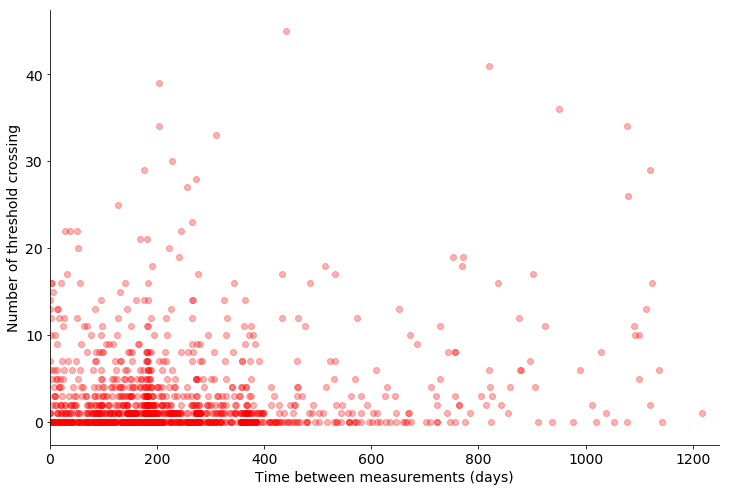

In [6]:
# Plot difference in signal vs difference in time, iterate through patients
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12,8))

for i, t in enumerate(tdifs):
    x = sum_absolute[i]
    plt.scatter(t, x, c='r', alpha=0.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time between measurements (days)')
plt.ylabel('Number of threshold crossing')
ax.set_xlim([0,1250])
plt.savefig('paper/figures/supplementary/scatter_plot_cutoff_1000.png')
plt.rcParams.update({'font.size': 12})

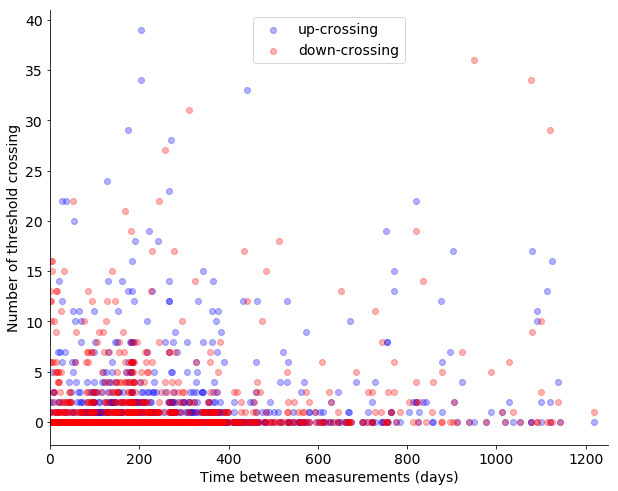

In [7]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10,8))

plt.scatter(np.concatenate(tdifs), np.concatenate(sum_ups), c='b', alpha=0.3, label='up-crossing')
plt.scatter(np.concatenate(tdifs), np.concatenate(sum_downs), c='r', alpha=0.3, label='down-crossing')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time between measurements (days)')
plt.ylabel('Number of threshold crossing')
ax.set_xlim([0,1250])
plt.legend(loc='upper center')
plt.savefig('paper/figures/supplementary/scatter_plot_cutoff_1000_updowns.png')
plt.rcParams.update({'font.size': 12})

In [8]:
# Need to get a colorscale of the categorical values
# Equal size percentile
t = np.concatenate(tdifs)
lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq[(t>=lims[-1]).reshape(-1,)] = i+1

In [9]:
print(lims)
np.unique(class_label_eq)

[ 98.  175.  225.4 361.2]


array([0., 1., 2., 3., 4.])

In [10]:
print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))
class_label_eq = class_label_eq.astype(int)
class_dict_eq = {
    0: '<98 days',
    1: '98 days - 175 days',
    2: '176 days - 225 days',
    3: '226 days - 361 days',
    4: '> 361 days'
}
hue_order_eq=['<98 days','98 days - 175 days','176 days - 225 days','226 days - 361 days','> 361 days']
class_lab_eq = []
for c in class_label_eq:
    class_lab_eq.append(class_dict_eq[c])

There are 1265 total differences, 253.0 in each quantile.


In [11]:
# Plot again
a = np.concatenate(sum_absolute)
# a_z = a[a>10]
df_adhoc = pd.DataFrame(np.abs(a).T, columns=['Number of threshold crossings'])
# df_adhoc['time between measurements'] = np.array(class_lab)[np.abs(a)>100]
df_adhoc['Time between measurements'] = np.array(class_lab_eq)[np.ones_like(a).astype(bool)]

In [12]:
# Ideal cubehelix parameters: n_colors=5, start=0.3, rot=-0.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1
cubehelix_pal = sns.cubehelix_palette(5, start=.3, rot=-.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1)

In [15]:
def swarmplot(df_adhoc, hue_order_eq, cubehelix_pal, maxval, savename=None):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(8,8))
    sns.swarmplot(x = 'Number of threshold crossings', y=[""]*len(df_adhoc), hue='Time between measurements', 
                  data=df_adhoc, hue_order=hue_order_eq, alpha=0.95, 
                  palette=cubehelix_pal, size=6)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(-0.5,maxval)

    if savename is not None:
        fig.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
        fig.savefig(f'{savename}.png', bbox_inches='tight')

    plt.rcParams.update({'font.size': 12})
    
def swarmboxplot(df_adhoc, hue_order_eq, cubehelix_pal, maxval, savename=None):
    # Try alternative visualization
    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(12,8))
    sns.swarmplot(x='Number of threshold crossings', y="Time between measurements", 
                  data=df_adhoc, order=hue_order_eq, alpha=0.95, palette=cubehelix_pal, orient='h')
    ax = sns.boxplot(x='Number of threshold crossings', y="Time between measurements", 
                data=df_adhoc, order=hue_order_eq, color='black',orient='h', ax=ax, fliersize=0)
    plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(ax.lines, color='k')
    ax.set_xlim(-0.5,maxval)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
        fig.savefig(f'{savename}.png', bbox_inches='tight')
    plt.rcParams.update({'font.size': 12})


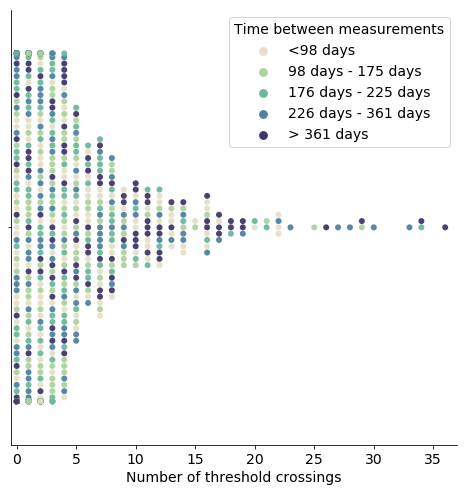

In [16]:
swarmplot(df_adhoc, hue_order_eq, cubehelix_pal,37, 
          savename='paper/figures/plots/swarmplot_threshold_crossing_1000_class1_cblind')

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


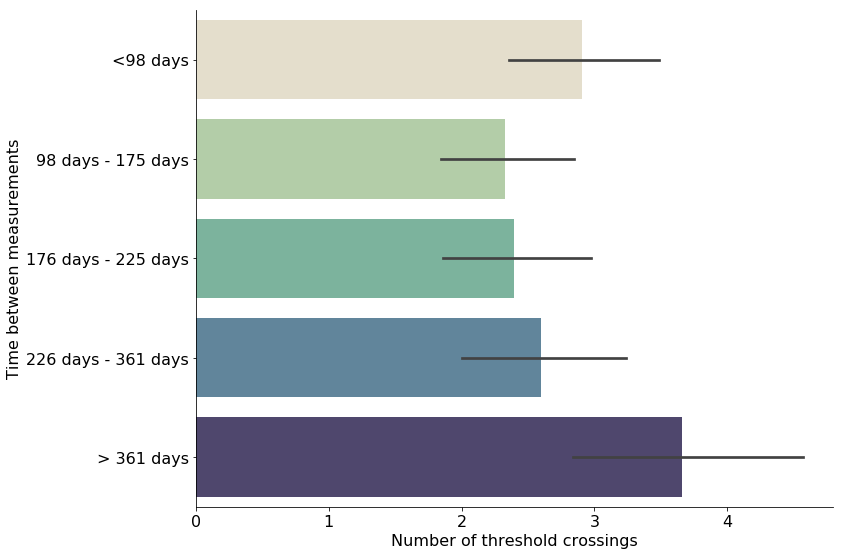

In [17]:
barplot(df_adhoc, hue_order_eq, cubehelix_pal, 
          savename='paper/figures/plots/barplot_threshold_crossing_1000_class1_cblind')

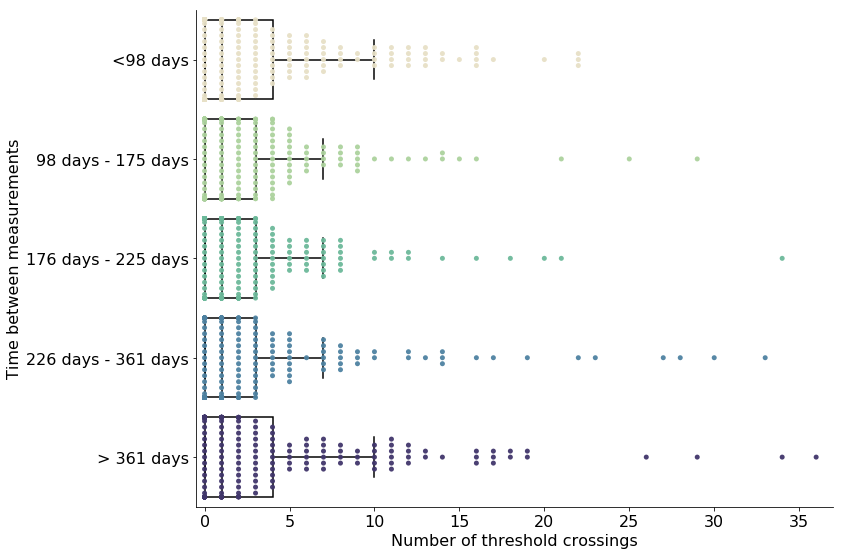

In [18]:
swarmboxplot(df_adhoc, hue_order_eq, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmboxplot_threshold_crossing_1000_class1_cblind')

In [19]:
# Statistical tests
# Test the distribution differences using indep ttest
from scipy.stats import ttest_ind, mannwhitneyu

def conduct_test(df_adhoc, hue_order_eq, mwu=False):
    vs = []
    for c in hue_order_eq:
        vs.append(df_adhoc[df_adhoc['Time between measurements']==c]['Number of threshold crossings'].as_matrix())
    # Conduct the test for each pair
    for i in range(5):
        for j in range(i+1,5):
            print('{} vs {}:'.format(hue_order_eq[i], hue_order_eq[j]))
            if mwu:
                m, p = mannwhitneyu(vs[i], vs[j], alternative='two-sided')
                print('\tMann Whitney U statistic: {:.3f}, p-val: {:.5f}'.format(m,p))
            else:
                t, p = ttest_ind(vs[i], vs[j], equal_var=False, nan_policy='omit')
                print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))
conduct_test(df_adhoc, hue_order_eq)

<98 days vs 98 days - 175 days:
	t-score: 1.524, p-val: 0.12826
<98 days vs 176 days - 225 days:
	t-score: 1.245, p-val: 0.21375
<98 days vs 226 days - 361 days:
	t-score: 0.709, p-val: 0.47844
<98 days vs > 361 days:
	t-score: -1.481, p-val: 0.13927
98 days - 175 days vs 176 days - 225 days:
	t-score: -0.176, p-val: 0.86042
98 days - 175 days vs 226 days - 361 days:
	t-score: -0.672, p-val: 0.50212
98 days - 175 days vs > 361 days:
	t-score: -2.709, p-val: 0.00704
176 days - 225 days vs 226 days - 361 days:
	t-score: -0.472, p-val: 0.63728
176 days - 225 days vs > 361 days:
	t-score: -2.454, p-val: 0.01453
226 days - 361 days vs > 361 days:
	t-score: -1.995, p-val: 0.04659


In [20]:
conduct_test(df_adhoc, hue_order_eq, mwu=True)

<98 days vs 98 days - 175 days:
	Mann Whitney U statistic: 33723.000, p-val: 0.54521
<98 days vs 176 days - 225 days:
	Mann Whitney U statistic: 33773.500, p-val: 0.37354
<98 days vs 226 days - 361 days:
	Mann Whitney U statistic: 34770.500, p-val: 0.31481
<98 days vs > 361 days:
	Mann Whitney U statistic: 32646.000, p-val: 0.75935
98 days - 175 days vs 176 days - 225 days:
	Mann Whitney U statistic: 31364.500, p-val: 0.75040
98 days - 175 days vs 226 days - 361 days:
	Mann Whitney U statistic: 32411.000, p-val: 0.61528
98 days - 175 days vs > 361 days:
	Mann Whitney U statistic: 30244.000, p-val: 0.37821
176 days - 225 days vs 226 days - 361 days:
	Mann Whitney U statistic: 31560.000, p-val: 0.83919
176 days - 225 days vs > 361 days:
	Mann Whitney U statistic: 29464.000, p-val: 0.25076
226 days - 361 days vs > 361 days:
	Mann Whitney U statistic: 30031.500, p-val: 0.21110


In [21]:
# Repeat for threshold at 5000
CLINICAL_THRESHOLD = 5000

def is_there_passage(x1_l,x2_l,thr):
    # Returns the signed passage (+1 if goes up, -1 if goes down)
    return np.multiply(np.sign(x2_l-x1_l),np.logical_xor(x1_l<thr, x2_l<thr).astype(int))
    

valdifs = []
kept_ids = []
tdifs = []
for patid in df_filtered_typ1['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs.append(is_there_passage(patient_ts.values[:-1,:],patient_ts.values[1:,:], CLINICAL_THRESHOLD))
        kept_ids.append(patid)
    except:
        continue

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [22]:
# Take the mean absolute value across all antibodies
sum_absolute = [np.abs(x).T.sum(axis=0) for x in valdifs]

In [23]:
# Plot again
a = np.concatenate(sum_absolute)
df_adhoc_5000 = pd.DataFrame(np.abs(a).T, columns=['Number of threshold crossings'])
df_adhoc_5000['Time between measurements'] = np.array(class_lab_eq)[np.ones_like(a).astype(bool)]

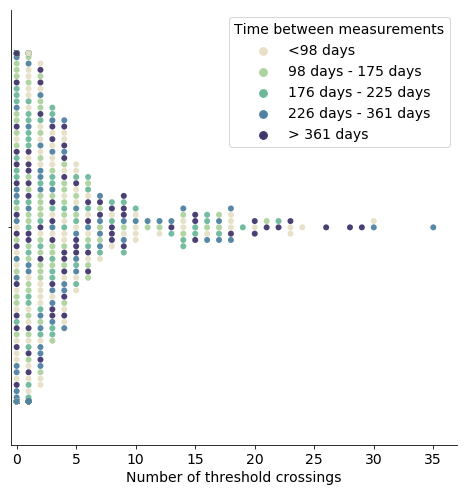

In [24]:
swarmplot(df_adhoc_5000, hue_order_eq, cubehelix_pal, 37, 
          savename='paper/figures/plots/swarmplot_threshold_crossing_5000_class1_cblind')

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


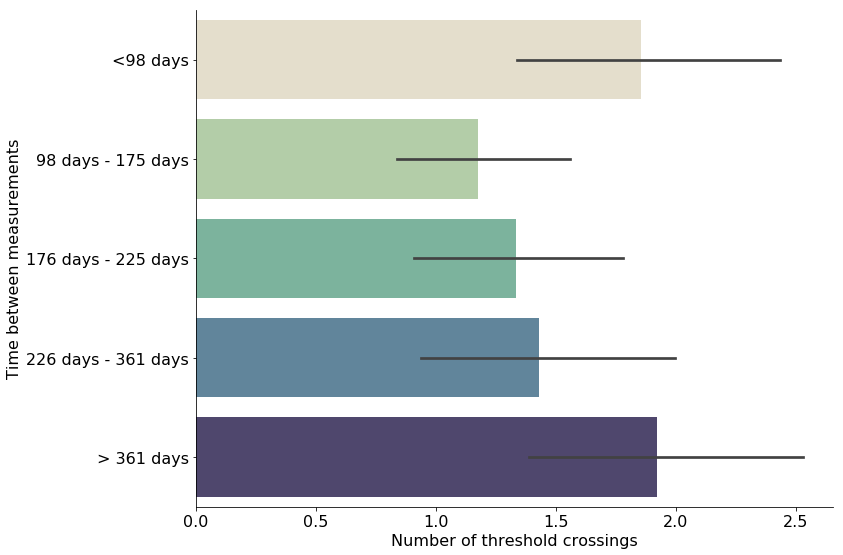

In [25]:
barplot(df_adhoc_5000, hue_order_eq, cubehelix_pal, 
          savename='paper/figures/plots/barplot_threshold_crossing_5000_class1_cblind')

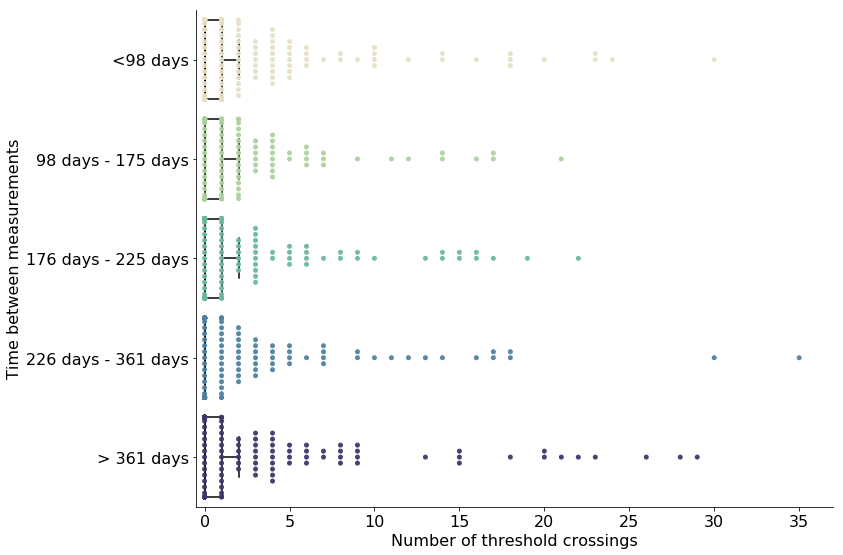

In [26]:
swarmboxplot(df_adhoc_5000, hue_order_eq, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmboxplot_threshold_crossing_5000_class1_cblind')

In [27]:
conduct_test(df_adhoc_5000, hue_order_eq=hue_order_eq)

<98 days vs 98 days - 175 days:
	t-score: 2.011, p-val: 0.04489
<98 days vs 176 days - 225 days:
	t-score: 1.453, p-val: 0.14690
<98 days vs 226 days - 361 days:
	t-score: 1.102, p-val: 0.27112
<98 days vs > 361 days:
	t-score: -0.162, p-val: 0.87147
98 days - 175 days vs 176 days - 225 days:
	t-score: -0.539, p-val: 0.59026
98 days - 175 days vs 226 days - 361 days:
	t-score: -0.774, p-val: 0.43918
98 days - 175 days vs > 361 days:
	t-score: -2.045, p-val: 0.04146
176 days - 225 days vs 226 days - 361 days:
	t-score: -0.272, p-val: 0.78560
176 days - 225 days vs > 361 days:
	t-score: -1.530, p-val: 0.12664
226 days - 361 days vs > 361 days:
	t-score: -1.201, p-val: 0.23028


# Class 2

In [28]:
df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
df_filtered_typ2['RSNR'].nunique()

20 patients need to be excluded as they only have one date of measurements.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


420

In [29]:
# Instead of taking the val difs, check if thresholds are crossed
CLINICAL_THRESHOLD = 1000
CLINICAL_THRESHOLD_2 = 5000

valdifs_2 = []
kept_ids_2 = []
tdifs_2 = []

valdifs_2_5000 = []
for patid in df_filtered_typ2['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ2.loc[patid], complete=True, analysis_type='2')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs_2.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs_2.append(is_there_passage(patient_ts.values[:-1,:],patient_ts.values[1:,:], CLINICAL_THRESHOLD))
        valdifs_2_5000.append(is_there_passage(patient_ts.values[:-1,:],
                                               patient_ts.values[1:,:], CLINICAL_THRESHOLD_2))
        kept_ids_2.append(patid)
    except:
        continue

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [30]:
# Equal size
t = np.concatenate(tdifs_2)

lims = np.percentile(t, [20, 40, 60, 80])
class_label_eq_2 = np.zeros(len(t))
for i, l in enumerate(lims[0:]):
    class_label_eq_2[np.logical_and(t<l+1,t>lims[i-1]).reshape(-1,)]=i
class_label_eq_2[(t>=lims[-1]).reshape(-1,)] = i+1

lims

array([ 97., 175., 225., 362.])

In [31]:
print("There are {} total differences, {} in each quantile.".format(t.shape[0], t.shape[0]/5))

class_label_eq_2 = class_label_eq_2.astype(int)
class_dict_eq_2 = {
    0: '<97 days',
    1: '97 days - 175 days',
    2: '176 days - 225 days',
    3: '226 days - 362 days',
    4: '> 362 days'
}
hue_order_eq_2 = ['<97 days','97 days - 175 days','176 days - 225 days','226 days - 362 days','> 362 days']
class_lab_eq_2 = []
for c in class_label_eq_2:
    class_lab_eq_2.append(class_dict_eq_2[c])

There are 1211 total differences, 242.2 in each quantile.


In [32]:
# Take the mean absolute value across all antibodies
sum_absolute_2 = [np.abs(x).T.sum(axis=0) for x in valdifs_2]
sum_absolute_2_5000 = [np.abs(x).T.sum(axis=0) for x in valdifs_2_5000]

In [33]:
a = np.concatenate(sum_absolute_2)
df_adhoc_2 = pd.DataFrame(np.abs(a).T, columns=['Number of threshold crossings'])
df_adhoc_2['Time between measurements'] = np.array(class_lab_eq_2)[np.ones_like(a).astype(bool)]

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


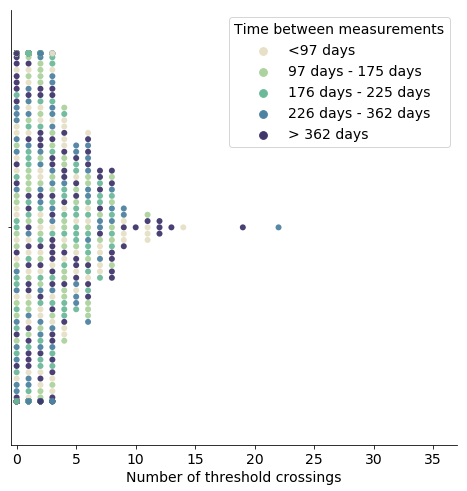

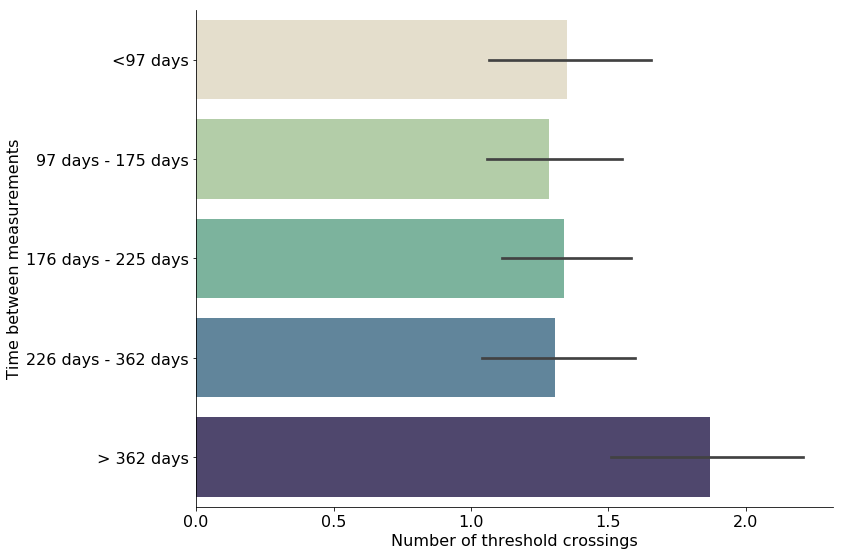

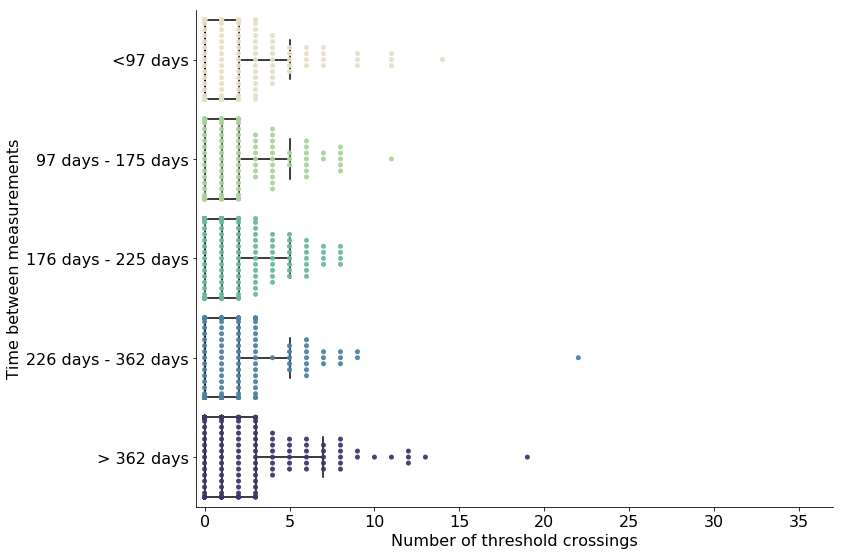

In [34]:
swarmplot(df_adhoc_2, hue_order_eq_2, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmplot_threshold_crossing_1000_class2_cblind')
barplot(df_adhoc_2, hue_order_eq_2, cubehelix_pal, 
          savename='paper/figures/plots/barplot_threshold_crossing_1000_class2_cblind')
swarmboxplot(df_adhoc_2, hue_order_eq_2, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmboxplot_threshold_crossing_1000_class2_cblind')

In [35]:
conduct_test(df_adhoc_2, hue_order_eq=hue_order_eq_2)

<97 days vs 97 days - 175 days:
	t-score: 0.344, p-val: 0.73094
<97 days vs 176 days - 225 days:
	t-score: 0.051, p-val: 0.95973
<97 days vs 226 days - 362 days:
	t-score: 0.218, p-val: 0.82772
<97 days vs > 362 days:
	t-score: -2.204, p-val: 0.02806
97 days - 175 days vs 176 days - 225 days:
	t-score: -0.323, p-val: 0.74687
97 days - 175 days vs 226 days - 362 days:
	t-score: -0.107, p-val: 0.91505
97 days - 175 days vs > 362 days:
	t-score: -2.636, p-val: 0.00871
176 days - 225 days vs 226 days - 362 days:
	t-score: 0.186, p-val: 0.85289
176 days - 225 days vs > 362 days:
	t-score: -2.387, p-val: 0.01742
226 days - 362 days vs > 362 days:
	t-score: -2.385, p-val: 0.01747


In [36]:
a = np.concatenate(sum_absolute_2_5000)
df_adhoc_2_5000 = pd.DataFrame(np.abs(a).T, columns=['Number of threshold crossings'])
df_adhoc_2_5000['Time between measurements'] = np.array(class_lab_eq_2)[np.ones_like(a).astype(bool)]

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


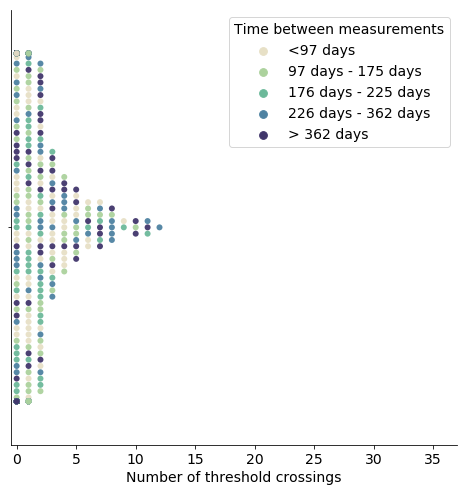

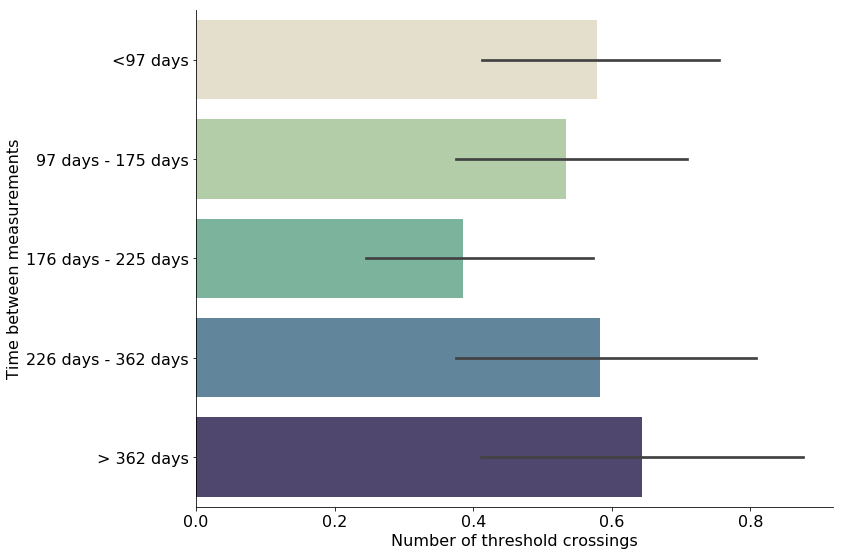

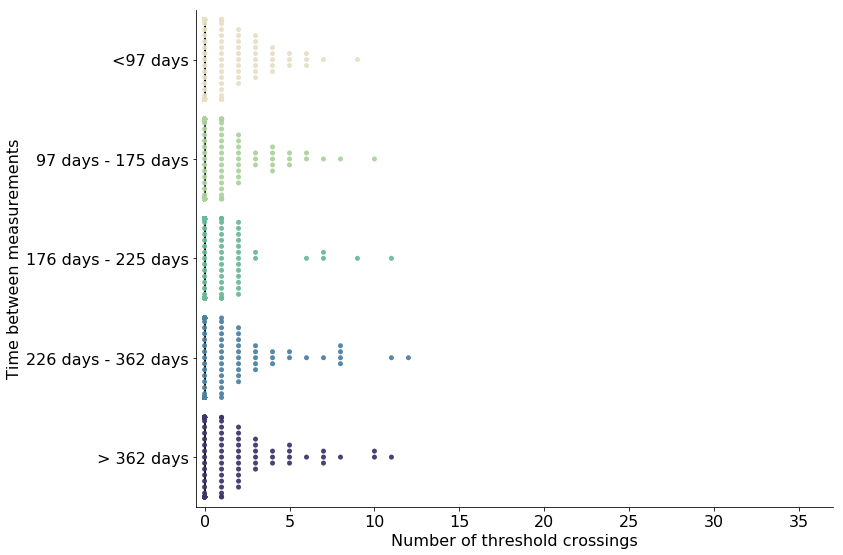

In [37]:
swarmplot(df_adhoc_2_5000, hue_order_eq_2, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmplot_threshold_crossing_5000_class2_cblind')
barplot(df_adhoc_2_5000, hue_order_eq_2, cubehelix_pal, 
          savename='paper/figures/plots/barplot_threshold_crossing_5000_class2_cblind')
swarmboxplot(df_adhoc_2_5000, hue_order_eq_2, cubehelix_pal, 37,
          savename='paper/figures/plots/swarmboxplot_threshold_crossing_5000_class2_cblind')

In [38]:
conduct_test(df_adhoc_2_5000, hue_order_eq=hue_order_eq_2)

<97 days vs 97 days - 175 days:
	t-score: 0.363, p-val: 0.71673
<97 days vs 176 days - 225 days:
	t-score: 1.599, p-val: 0.11055
<97 days vs 226 days - 362 days:
	t-score: -0.029, p-val: 0.97677
<97 days vs > 362 days:
	t-score: -0.447, p-val: 0.65514
97 days - 175 days vs 176 days - 225 days:
	t-score: 1.210, p-val: 0.22686
97 days - 175 days vs 226 days - 362 days:
	t-score: -0.348, p-val: 0.72822
97 days - 175 days vs > 362 days:
	t-score: -0.763, p-val: 0.44599
176 days - 225 days vs 226 days - 362 days:
	t-score: -1.419, p-val: 0.15655
176 days - 225 days vs > 362 days:
	t-score: -1.847, p-val: 0.06545
226 days - 362 days vs > 362 days:
	t-score: -0.377, p-val: 0.70667
